<a href="https://colab.research.google.com/github/sharma301aditya/sargam_token_prediction/blob/main/context_gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

# This will prompt you to select a file
uploaded = files.upload()

# If you uploaded a CSV, you can load it directly into pandas
import pandas as pd

# Replace 'data.csv' with the actual filename you uploaded
df = pd.read_csv('/content/shuffled_FINAL_DATASET copy.csv')
print(df.head())


Saving predictions_with_evaluation (2).csv to predictions_with_evaluation (2).csv


FileNotFoundError: [Errno 2] No such file or directory: '/content/shuffled_FINAL_DATASET copy.csv'

✅ Using device: cuda
📂 Loading dataset...
Training: 5152, Validation: 644, Test: 645


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🚀 Starting Training...
Epoch 1/5 - Train Loss: 0.3710
Epoch 2/5 - Train Loss: 0.1948
Epoch 3/5 - Train Loss: 0.1596
Epoch 4/5 - Train Loss: 0.1170
Epoch 5/5 - Train Loss: 0.1076
💾 Model saved to ./saved_classification_model/

📊 Evaluating on Test Set...


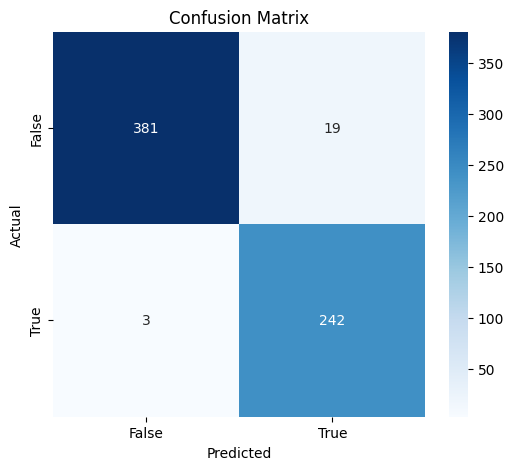


Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.95      0.97       400
        True       0.93      0.99      0.96       245

    accuracy                           0.97       645
   macro avg       0.96      0.97      0.96       645
weighted avg       0.97      0.97      0.97       645


🎶 Sargam Correction/Generation...


Some weights of the model checkpoint at google-bert/bert-base-multilingual-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



🎵 Suggestions for [MASK]:
- pa (25.67%)
- sa (23.06%)
- ma (16.60%)


In [ ]:
# --- 0. Install/Import Required Libraries ---
!pip install transformers torch seaborn -q

import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from transformers import BertTokenizer, BertForSequenceClassification, BertForMaskedLM
from torch.optim import AdamW
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
import os

# --- 1. Configuration and Setup ---
MODEL_NAME = "google-bert/bert-base-multilingual-uncased"
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 2e-5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# --- 2. Data Loading ---
print("📂 Loading dataset...")

df = pd.read_csv(
    "/content/shuffled_FINAL_DATASET copy.csv",
    names=["lyrics", "sargam", "label"],
    skiprows=1   # Skip header row if present
)

# --- 2.1 Label Cleaning ---
def clean_labels(x):
    try:
        if isinstance(x, str):
            x = x.strip().lower()
            if x in ["yes", "true", "1"]: return 1
            if x in ["no", "false", "0"]: return 0
        return int(x)
    except Exception:
        return 0

df["label"] = df["label"].apply(clean_labels)

# --- 2.2 Split Data ---
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42, stratify=test_df["label"])

print(f"Training: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")

# --- 3. Dataset Class ---
class SentencePairDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.lyrics = dataframe["lyrics"].tolist()
        self.sargam = dataframe["sargam"].tolist()
        self.labels = dataframe["label"].tolist()
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        lyrics = str(self.lyrics[idx])
        sargam = str(self.sargam[idx])
        label = int(self.labels[idx])  # ensure int

        encoding = self.tokenizer.encode_plus(
            lyrics,
            sargam,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_token_type_ids=True,
            return_attention_mask=True,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "token_type_ids": encoding["token_type_ids"].flatten(),
            "labels": torch.tensor(label, dtype=torch.long)
        }

# --- 4. Data Loaders ---
train_loader = DataLoader(SentencePairDataset(train_df, tokenizer, MAX_LEN), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(SentencePairDataset(val_df, tokenizer, MAX_LEN), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(SentencePairDataset(test_df, tokenizer, MAX_LEN), batch_size=BATCH_SIZE, shuffle=False)

# --- 5. Model Initialization ---
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model.to(device)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

# --- 6. Training ---
def train_epoch(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

print("\n🚀 Starting Training...")
for epoch in range(EPOCHS):
    train_loss = train_epoch(model, train_loader, optimizer, device)
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f}")

# --- 7. Save Model ---
output_dir = "./saved_classification_model/"
os.makedirs(output_dir, exist_ok=True)
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"💾 Model saved to {output_dir}")

# --- 8. Evaluation ---
def evaluate(model, data_loader, device):
    model.eval()
    preds, true = [], []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            token_type_ids = batch["token_type_ids"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)

            preds.extend(predictions.cpu().numpy())
            true.extend(labels.cpu().numpy())
    return true, preds

print("\n📊 Evaluating on Test Set...")
y_true, y_pred = evaluate(model, test_loader, device)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["False","True"], yticklabels=["False","True"])
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["False","True"]))

# --- 9. Sargam Correction/Generation ---
print("\n🎶 Sargam Correction/Generation...")

mlm_model = BertForMaskedLM.from_pretrained(MODEL_NAME)
mlm_model.to(device)
mlm_model.eval()

valid_sargam_syllables = ["sa","re","ga","ma","pa","dha","ni"]

def suggest_sargam_keys(lyrics, sargam_with_mask, model, tokenizer, device, top_k=3):
    text = lyrics + " [SEP] " + sargam_with_mask
    inputs = tokenizer(text, return_tensors="pt").to(device)
    input_ids = inputs["input_ids"]

    mask_token_indices = (input_ids == tokenizer.mask_token_id).nonzero(as_tuple=True)[1]
    if len(mask_token_indices) == 0:
        print("⚠️ No [MASK] found.")
        return

    with torch.no_grad():
        outputs = model(**inputs)
        predictions = outputs.logits

    valid_ids = []
    for s in valid_sargam_syllables:
        token_ids = tokenizer.encode(s, add_special_tokens=False)
        if len(token_ids) == 1:
            valid_ids.append(token_ids[0])
    valid_ids_tensor = torch.tensor(valid_ids, device=device)

    for idx in mask_token_indices:
        mask_logits = predictions[0, idx, :]
        filtered_logits = torch.full_like(mask_logits, -float("inf"))
        filtered_logits[valid_ids_tensor] = mask_logits[valid_ids_tensor]

        probs = F.softmax(filtered_logits, dim=-1)
        top_k_tokens = torch.topk(probs, top_k, dim=-1)

        print(f"\n🎵 Suggestions for [MASK]:")
        for i in range(top_k):
            token_id = top_k_tokens.indices[i].item()
            token_prob = top_k_tokens.values[i].item()
            token = tokenizer.decode([token_id])
            print(f"- {token} ({token_prob:.2%})")

# Example usage
lyrics_ex = "शिव कैलाशों के वासी"
sargam_masked = "Ga Re Ga Pa Ma Ga Re Ga Re Sa [MASK]"
suggest_sargam_keys(lyrics_ex, sargam_masked, mlm_model, tokenizer, device)




In [ ]:
# --- 0. Install/Import Required Libraries ---
try:
    import pandas as pd
    import torch
    from transformers import BertTokenizer, BertForMaskedLM
    import torch.nn.functional as F
    from tqdm import tqdm
except ImportError:
    print("Installing required libraries: pandas, torch, transformers, tqdm")
    !pip install pandas torch transformers tqdm -q
    import pandas as pd
    import torch
    from transformers import BertTokenizer, BertForMaskedLM
    import torch.nn.functional as F
    from tqdm import tqdm
import os

# --- 1. Configuration ---
MODEL_NAME = "google-bert/bert-base-multilingual-uncased"
INPUT_CSV_PATH = "input_data.csv"
OUTPUT_CSV_PATH = "predictions_output.csv"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 2. Create a Dummy Input CSV for Demonstration ---
# In a real scenario, you would already have this file.
print(f"📄 Creating a dummy input file: '{INPUT_CSV_PATH}'")
dummy_data = {
    'lyrics': [
        "शिव कैलाशों के वासी",
        "सत्यम शिवम सुंदरम",
        "Twinkle twinkle little star",
        "Old MacDonald had a farm"
    ],
    'sargam': [
        "Ga Re Ga Pa Ma Ga Re Ga Re Sa [MASK]",
        "sa re ga ma [MASK]",
        "sa sa ga ga ma ma [MASK]",
        "sa re ga ma pa [MASK]"
    ]
}
pd.DataFrame(dummy_data).to_csv(INPUT_CSV_PATH, index=False)
print("✅ Dummy file created successfully.")


# --- 3. Model and Tokenizer Setup ---
print(f"\n🧠 Loading model '{MODEL_NAME}' onto device: {DEVICE}")
model = BertForMaskedLM.from_pretrained(MODEL_NAME).to(DEVICE)
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model.eval() # Set model to evaluation mode

# --- 4. Define Valid Sargam "Alphabet" and Pre-compute Token IDs ---
# This is an efficient way to constrain the model's predictions.
valid_sargam_syllables = ["sa", "re", "ga", "ma", "pa", "dha", "ni"]
valid_ids = []
for syllable in valid_sargam_syllables:
    token_ids = tokenizer.encode(syllable, add_special_tokens=False)
    if len(token_ids) == 1: # Ensure it's a single token
        valid_ids.append(token_ids[0])

valid_ids_tensor = torch.tensor(valid_ids, device=DEVICE)
print(f"✅ Model setup complete. Using {len(valid_ids)} valid sargam tokens for prediction.")


# --- 5. Core Prediction Function ---
def predict_best_sargam_token(lyrics, sargam_with_mask, model, tokenizer, valid_token_ids):
    """
    Predicts the single most likely sargam token for a [MASK].

    Returns:
        A dictionary {'token': str, 'score': float} or {'token': None, 'score': 0.0} on failure.
    """
    text = f"{lyrics} [SEP] {sargam_with_mask}"
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128).to(DEVICE)
    input_ids = inputs["input_ids"]

    try:
        mask_index = (input_ids[0] == tokenizer.mask_token_id).nonzero(as_tuple=True)[0][0]
    except IndexError:
        return {'token': '[ERROR: MASK not found]', 'score': 0.0}

    with torch.no_grad():
        logits = model(**inputs).logits

    mask_logits = logits[0, mask_index, :]
    filtered_logits = torch.full_like(mask_logits, -float("inf"))
    filtered_logits[valid_token_ids] = mask_logits[valid_token_ids]

    probs = F.softmax(filtered_logits, dim=-1)

    # Get only the top 1 prediction
    top_prediction = torch.topk(probs, 1)

    best_token_id = top_prediction.indices[0].item()
    best_score = top_prediction.values[0].item()

    if best_score > 0:
        predicted_token = tokenizer.decode(best_token_id)
        return {'token': predicted_token, 'score': best_score}
    else:
        return {'token': '[No valid prediction]', 'score': 0.0}

# --- 6. Main Processing Script ---
print(f"\n🚀 Starting batch processing of '{INPUT_CSV_PATH}'...")

# Load the input CSV
try:
    df = pd.read_csv(INPUT_CSV_PATH)
except FileNotFoundError:
    print(f"❌ ERROR: Input file not found at '{INPUT_CSV_PATH}'. Please check the path.")
    exit()

# Prepare lists to store results
predicted_tokens = []
confidence_scores = []

# Use tqdm for a nice progress bar
for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Predicting tokens"):
    lyrics = row['lyrics']
    sargam = row['sargam']

    # Get the prediction
    prediction = predict_best_sargam_token(lyrics, sargam, model, tokenizer, valid_ids_tensor)

    # Append results to our lists
    predicted_tokens.append(prediction['token'])
    confidence_scores.append(prediction['score'])

# --- 7. Save Results to a New CSV ---
print("\n📝 Assembling final results...")

# Add the new columns to the DataFrame
df['predicted_token'] = predicted_tokens
df['confidence_score'] = confidence_scores

# Create the completed sargam sequence by replacing [MASK]
# Using .astype(str) to handle potential errors if a token is not a string
df['completed_sargam'] = df.apply(
    lambda row: str(row['sargam']).replace('[MASK]', str(row['predicted_token'])),
    axis=1
)

# Save the final DataFrame
df.to_csv(OUTPUT_CSV_PATH, index=False)

print(f"\n✅ All done! Results have been saved to '{OUTPUT_CSV_PATH}'.")
print("\n--- Output Preview ---")
print(df.head())

In [ ]:
import pandas as pd
from google.colab import files

# This will prompt you to select a file
uploaded = files.upload()

# --- Load CSV ---
df = pd.read_csv("/content/label_true.csv")  # replace with your file path

# --- Keep only 2 samples per unique lyrics ---
df_limited = df.groupby("lyrics").head(2).reset_index(drop=True)

# --- Save the reduced CSV if needed ---
df_limited.to_csv("/content/limited_dataset.csv", index=False)

print("✅ Dataset reduced: max 2 rows per unique lyrics")
print(df_limited.head(10))


Saving label_true.csv to label_true (1).csv
✅ Dataset reduced: max 2 rows per unique lyrics
                                lyrics  \
0                  राम का गुणगान करिये   
1                  राम का गुणगान करिये   
2         अच्युतं केशवं कृष्ण दामोदरंर   
3         अच्युतं केशवं कृष्ण दामोदरंर   
4   हरे कृष्ण, हरे कृष्ण, कृष्ण कृष्ण    
5           हे शारदे माँ  हे शारदे माँ   
6           हे शारदे माँ  हे शारदे माँ   
7              ॐ भू भव सव तत्सत वर्णाय   
8              ॐ भू भव सव तत्सत वर्णाय   
9  मीठे रस से  भर यो री राधा रानी लागे   

                                              sargam  label  
0                                Sa Re Na Dha Mat Re   True  
1                               rak gak s nak pa gak   True  
2                Sa Re Ga Ga Ma Ga Re Sa Re Re Ga Re   True  
3        rak gak ma ma mat ma gak rak gak gak ma gak   True  
4                Ga Ga Ma Ma Ga Re Ga Ga Re Sa Re Re   True  
5  gak gak gak ma ma gak rak rak rak rak gak gak ...   True  
6       ga 

In [ ]:
import pandas as pd

# --- Load CSV ---
df = pd.read_csv("/content/limited_dataset.csv")  # your reduced CSV

# --- Replace last token in Sargam with [MASK] ---
def mask_last_sargam(sargam):
    tokens = str(sargam).split()
    if len(tokens) == 0:
        return "[MASK]"
    tokens[-1] = "[MASK]"
    return " ".join(tokens)

df['sargam'] = df['sargam'].apply(mask_last_sargam)

# --- Save updated CSV ---
df.to_csv("/content/masked_sargam_dataset.csv", index=False)

print("✅ Last token in Sargam replaced with [MASK] for each row")
print(df.head(10))


✅ Last token in Sargam replaced with [MASK] for each row
                                lyrics  \
0                  राम का गुणगान करिये   
1                  राम का गुणगान करिये   
2         अच्युतं केशवं कृष्ण दामोदरंर   
3         अच्युतं केशवं कृष्ण दामोदरंर   
4   हरे कृष्ण, हरे कृष्ण, कृष्ण कृष्ण    
5           हे शारदे माँ  हे शारदे माँ   
6           हे शारदे माँ  हे शारदे माँ   
7              ॐ भू भव सव तत्सत वर्णाय   
8              ॐ भू भव सव तत्सत वर्णाय   
9  मीठे रस से  भर यो री राधा रानी लागे   

                                              sargam  label  
0                            Sa Re Na Dha Mat [MASK]   True  
1                            rak gak s nak pa [MASK]   True  
2            Sa Re Ga Ga Ma Ga Re Sa Re Re Ga [MASK]   True  
3     rak gak ma ma mat ma gak rak gak gak ma [MASK]   True  
4            Ga Ga Ma Ma Ga Re Ga Ga Re Sa Re [MASK]   True  
5  gak gak gak ma ma gak rak rak rak rak gak gak ...   True  
6    ga ga ga mat mat ga ra ra ra ra ga ga ra 

context

In [ ]:
# ==============================================================================
# Final Script: Sargam Prediction from Lyrics
#
# Description:
# This script reads a CSV file containing lyrics and corresponding Sargam
# sequences. For each row, it uses a pre-trained BERT Masked Language Model
# to predict a missing `[MASK]` token in the Sargam sequence.
#
# Input:
# A CSV file with at least two columns: 'lyrics' and 'sargam'.
# The 'sargam' column should contain '[MASK]' for the token to be predicted.
#
# Output:
# A new CSV file with the original data plus three new columns:
#   - 'predicted_token': The model's top prediction for the [MASK].
#   - 'confidence_score': The model's confidence in the prediction.
#   - 'completed_sargam': The sargam sequence with [MASK] replaced.
#
# Author: Gemini
# Date: September 7, 2025
# ==============================================================================

# --- 0. Install/Import Required Libraries ---
try:
    import pandas as pd
    import torch
    from transformers import BertTokenizer, BertForMaskedLM
    import torch.nn.functional as F
    from tqdm import tqdm
except ImportError:
    print("Installing required libraries: pandas, torch, transformers, tqdm")
    # This command is for environments like Google Colab
    !pip install pandas torch transformers tqdm -q
    import pandas as pd
    import torch
    from transformers import BertTokenizer, BertForMaskedLM
    import torch.nn.functional as F
    from tqdm import tqdm
import os

# --- 1. Configuration ---
# --- (USER: PLEASE EDIT THESE VALUES) ---
MODEL_NAME = "google-bert/bert-base-multilingual-uncased"
INPUT_CSV_PATH = "/content/masked_sargam_dataset.csv"
OUTPUT_CSV_PATH = "predictions_output.csv"
# --- (END OF USER EDITS) ---

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def create_dummy_input_file():
    """Creates a dummy CSV for demonstration if the input file doesn't exist."""
    if not os.path.exists(INPUT_CSV_PATH):
        print(f"📄 Input file not found. Creating a dummy file for demonstration: '{INPUT_CSV_PATH}'")
        dummy_data = {
            'lyrics': [
                "शिव कैलाशों के वासी",
                "सत्यम शिवम सुंदरम",
                "Twinkle twinkle little star",
                "Old MacDonald had a farm"
            ],
            'sargam': [
                "Ga Re Ga Pa Ma Ga Re Ga Re Sa [MASK]",
                "sa re ga ma [MASK]",
                "sa sa ga ga ma ma [MASK]",
                "sa re ga ma pa [MASK]"
            ]
        }
        pd.DataFrame(dummy_data).to_csv(INPUT_CSV_PATH, index=False)
        print("✅ Dummy file created. You can replace this with your own data.")


def predict_best_sargam_token(lyrics, sargam_with_mask, model, tokenizer, valid_token_ids):
    """
    Predicts the single most likely sargam token for a [MASK] using a BERT model.

    Args:
        lyrics (str): The lyrical context for the prediction.
        sargam_with_mask (str): The sargam sequence containing a '[MASK]' token.
        model (BertForMaskedLM): The pre-trained masked language model.
        tokenizer (BertTokenizer): The tokenizer for the model.
        valid_token_ids (torch.Tensor): A tensor containing the token IDs of valid predictions.

    Returns:
        dict: A dictionary containing the predicted 'token' and its 'score'.
              Returns an error token on failure.
    """
    text = f"{lyrics} [SEP] {sargam_with_mask}"
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128).to(DEVICE)
    input_ids = inputs["input_ids"]

    try:
        mask_index = (input_ids[0] == tokenizer.mask_token_id).nonzero(as_tuple=True)[0][0]
    except IndexError:
        return {'token': '[ERROR: MASK not found]', 'score': 0.0}

    with torch.no_grad():
        logits = model(**inputs).logits

    mask_logits = logits[0, mask_index, :]

    # Filter the logits to only include scores for valid sargam tokens
    filtered_logits = torch.full_like(mask_logits, -float("inf"))
    filtered_logits[valid_token_ids] = mask_logits[valid_token_ids]

    probs = F.softmax(filtered_logits, dim=-1)

    # Get only the top 1 prediction
    top_prediction = torch.topk(probs, 1)

    best_token_id = top_prediction.indices[0].item()
    best_score = top_prediction.values[0].item()

    if best_score > 0:
        predicted_token = tokenizer.decode(best_token_id)
        return {'token': predicted_token, 'score': best_score}
    else:
        return {'token': '[No valid prediction]', 'score': 0.0}


def main():
    """Main function to run the entire prediction pipeline."""
    create_dummy_input_file()

    print(f"🧠 Loading model '{MODEL_NAME}' onto device: {DEVICE}")
    model = BertForMaskedLM.from_pretrained(MODEL_NAME).to(DEVICE)
    tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
    model.eval()

    valid_sargam_syllables = ["sa", "re", "ga", "ma", "pa", "dha", "ni"]
    valid_ids = [
        tid[0] for s in valid_sargam_syllables
        if len(tid := tokenizer.encode(s, add_special_tokens=False)) == 1
    ]
    valid_ids_tensor = torch.tensor(valid_ids, device=DEVICE)
    print(f"✅ Model setup complete. Constraining predictions to {len(valid_ids)} valid sargam tokens.")

    print(f"\n🚀 Starting batch processing of '{INPUT_CSV_PATH}'...")
    try:
        df = pd.read_csv(INPUT_CSV_PATH)
    except FileNotFoundError:
        print(f"❌ ERROR: Input file not found at '{INPUT_CSV_PATH}'. Please check the path.")
        return

    # --- Robustness Checks ---
    required_columns = ['lyrics', 'sargam']
    if not all(col in df.columns for col in required_columns):
        print(f"❌ ERROR: Input CSV must contain the columns: {required_columns}")
        return
    if df.empty:
        print("⚠️ Warning: Input CSV file is empty. No processing will be done.")
        return

    predicted_tokens = []
    confidence_scores = []

    for _, row in tqdm(df.iterrows(), total=df.shape[0], desc="Predicting tokens"):
        lyrics = str(row['lyrics'])
        sargam = str(row['sargam'])

        if '[MASK]' in sargam:
            prediction = predict_best_sargam_token(lyrics, sargam, model, tokenizer, valid_ids_tensor)
        else:
            prediction = {'token': '[No MASK in input]', 'score': 0.0}

        predicted_tokens.append(prediction['token'])
        confidence_scores.append(prediction['score'])

    print("\n📝 Assembling final results...")
    df['predicted_token'] = predicted_tokens
    df['confidence_score'] = [f"{score:.2%}" for score in confidence_scores] # Format as percentage
    df['completed_sargam'] = df.apply(
        lambda row: row['sargam'].replace('[MASK]', row['predicted_token']),
        axis=1
    )

    df.to_csv(OUTPUT_CSV_PATH, index=False)
    print(f"\n✅ All done! Results have been saved to '{OUTPUT_CSV_PATH}'.")
    print("\n--- Output Preview ---")
    print(df.head().to_string())


if __name__ == "__main__":
    main()

🧠 Loading model 'google-bert/bert-base-multilingual-uncased' onto device: cuda


Some weights of the model checkpoint at google-bert/bert-base-multilingual-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


✅ Model setup complete. Constraining predictions to 7 valid sargam tokens.

🚀 Starting batch processing of '/content/masked_sargam_dataset.csv'...


Predicting tokens: 100%|██████████| 178/178 [00:02<00:00, 81.89it/s]


📝 Assembling final results...

✅ All done! Results have been saved to 'predictions_output.csv'.

--- Output Preview ---
                               lyrics                                          sargam  label predicted_token confidence_score                            completed_sargam
0                 राम का गुणगान करिये                         Sa Re Na Dha Mat [MASK]   True              ni           33.50%                         Sa Re Na Dha Mat ni
1                 राम का गुणगान करिये                         rak gak s nak pa [MASK]   True              ni           33.80%                         rak gak s nak pa ni
2        अच्युतं केशवं कृष्ण दामोदरंर         Sa Re Ga Ga Ma Ga Re Sa Re Re Ga [MASK]   True              ga           37.56%         Sa Re Ga Ga Ma Ga Re Sa Re Re Ga ga
3        अच्युतं केशवं कृष्ण दामोदरंर  rak gak ma ma mat ma gak rak gak gak ma [MASK]   True              ma           84.56%  rak gak ma ma mat ma gak rak gak gak ma ma
4  हरे कृष्ण, हरे कृष्ण, कृष्

In [ ]:
# ==============================================================================
# Final Script: Fine-Tuning and Evaluating a Sargam Prediction Model
#
# Description:
# This script fine-tunes a BERT Masked Language Model to predict the final
# token in a Sargam sequence based on lyrics.
#
# IT REQUIRES PRE-SPLIT DATA: You must provide separate CSV files for
# training, validation, and testing.
#
# The model is trained on the training set, monitored with the validation set,
# and finally evaluated on the held-out test set.
#
# Author: Gemini
# Date: September 8, 2025
# ==============================================================================

# --- 0. Imports ---
try:
    import pandas as pd
    import torch
    from transformers import BertTokenizer, BertForMaskedLM, DataCollatorForLanguageModeling, Trainer, TrainingArguments
    from torch.utils.data import Dataset
    import torch.nn.functional as F
    from tqdm import tqdm
    import numpy as np
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    from sklearn.model_selection import train_test_split
    import matplotlib.pyplot as plt
    import seaborn as sns
except ImportError:
    print("Installing required libraries...")
    # This command is for environments like Google Colab
    !pip install pandas torch transformers datasets scikit-learn matplotlib seaborn -q
    import pandas as pd
    import torch
    from transformers import BertTokenizer, BertForMaskedLM, DataCollatorForLanguageModeling, Trainer, TrainingArguments
    from torch.utils.data import Dataset
    import torch.nn.functional as F
    from tqdm import tqdm
    import numpy as np
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    from sklearn.model_selection import train_test_split
    import matplotlib.pyplot as plt
    import seaborn as sns
import os

# --- 1. Configuration ---
# --- (USER: YOU MUST PROVIDE PATHS TO YOUR 3 PRE-SPLIT FILES) ---
MODEL_NAME = "google-bert/bert-base-multilingual-uncased"
TRAIN_CSV_PATH = "train_data.csv"
VALIDATION_CSV_PATH = "validation_data.csv"
TEST_CSV_PATH = "test_data.csv"
OUTPUT_CSV_PATH = "predictions_with_evaluation.csv"
MODEL_OUTPUT_DIR = "./mlm_sargam_model"
# --- (END OF USER EDITS) ---

# Training Hyperparameters
EPOCHS = 3
BATCH_SIZE = 8
MAX_LEN = 128
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 2. Data Loading ---
def load_pre_split_data():
    """Loads pre-split train, validation, and test data files."""
    try:
        print("📁 Loading pre-split data files...")
        train_df = pd.read_csv(TRAIN_CSV_PATH)
        val_df = pd.read_csv(VALIDATION_CSV_PATH)
        test_df = pd.read_csv(TEST_CSV_PATH)
        print(f"✅ Loaded {len(train_df)} train, {len(val_df)} validation, and {len(test_df)} test examples.")
        return train_df, val_df, test_df
    except FileNotFoundError as e:
        print(f"❌ ERROR: A required data file was not found. {e}")
        print("Please ensure the file paths in the Configuration section are correct.")
        return None, None, None

def prepare_data_for_mlm(df):
    """Prepares a DataFrame for Masked Language Model training and prediction."""
    # Ensure data is string
    df['sargam'] = df['sargam'].astype(str)
    df['lyrics'] = df['lyrics'].astype(str)

    # Create the masked sargam (question)
    df['masked_sargam'] = df['sargam'].apply(lambda x: ' '.join(x.split()[:-1] + ['[MASK]']))

    # Create the full text input for the model
    df['training_text'] = df['lyrics'] + " [SEP] " + df['masked_sargam']
    return df

# --- 3. Custom Dataset ---
class SargamDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text, add_special_tokens=True, truncation=True,
            max_length=self.max_len, padding='max_length', return_tensors='pt'
        )
        return {k: v.squeeze(0) for k, v in encoding.items()}

# --- 4. Prediction & Evaluation Function ---
def evaluate_on_test_set(model, tokenizer, test_df):
    """Runs prediction on the test set and prints a full evaluation report."""
    print("\n\n--- Final Evaluation on Test Set ---")

    # Extract ground truth labels from the original, unmasked sargam
    y_true = [s.split()[-1] for s in test_df['sargam']]
    y_pred = []
    confidences = []

    valid_sargam_syllables = ["sa", "re", "ga", "ma", "pa", "dha", "ni"]
    valid_ids = [tid[0] for s in valid_sargam_syllables if len(tid := tokenizer.encode(s, add_special_tokens=False)) == 1]
    valid_ids_tensor = torch.tensor(valid_ids, device=DEVICE)

    model.eval()
    for _, row in tqdm(test_df.iterrows(), total=test_df.shape[0], desc="Evaluating on test data"):
        text = row['training_text']
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=MAX_LEN).to(DEVICE)

        with torch.no_grad():
            logits = model(**inputs).logits

        try:
            mask_index = (inputs.input_ids[0] == tokenizer.mask_token_id).nonzero(as_tuple=True)[0][0]
            mask_logits = logits[0, mask_index, :]

            filtered_logits = torch.full_like(mask_logits, -float("inf"))
            filtered_logits[valid_ids_tensor] = mask_logits[valid_ids_tensor]

            probs = F.softmax(filtered_logits, dim=-1)
            best_id = torch.argmax(probs).item()

            y_pred.append(tokenizer.decode(best_id))
            confidences.append(probs[best_id].item())
        except IndexError:
            y_pred.append("[ERROR]")
            confidences.append(0.0)

    # --- Save detailed results to CSV ---
    results_df = test_df.copy()
    results_df['predicted_token'] = y_pred
    results_df['ground_truth_token'] = y_true
    results_df['is_correct'] = np.where(results_df['predicted_token'] == results_df['ground_truth_token'], 'Yes', 'No')
    results_df['confidence'] = [f"{s:.2%}" for s in confidences]
    results_df.to_csv(OUTPUT_CSV_PATH, index=False)
    print(f"\n✅ Detailed evaluation results saved to '{OUTPUT_CSV_PATH}'")

    # --- Print Evaluation Metrics ---
    print("\n🎯 Overall Accuracy:", f"{accuracy_score(y_true, y_pred):.2%}")
    print("\n📊 Classification Report:")
    unique_labels = sorted(list(set(y_true) | set(y_pred)))
    print(classification_report(y_true, y_pred, labels=unique_labels, zero_division=0))

    # --- Display Confusion Matrix ---
    cm = confusion_matrix(y_true, y_pred, labels=unique_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
    plt.title('Confusion Matrix on Test Set')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


# --- 5. Main Execution ---
def main():
    # Load pre-split data
    train_df, val_df, test_df = load_pre_split_data()
    if train_df is None: # Check if loading failed
        return

    # Prepare data for MLM
    train_df = prepare_data_for_mlm(train_df)
    val_df = prepare_data_for_mlm(val_df)
    test_df = prepare_data_for_mlm(test_df)

    # Initialize Tokenizer and Model
    tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
    model = BertForMaskedLM.from_pretrained(MODEL_NAME).to(DEVICE)

    # Create Datasets
    train_dataset = SargamDataset(train_df['training_text'].tolist(), tokenizer, MAX_LEN)
    val_dataset = SargamDataset(val_df['training_text'].tolist(), tokenizer, MAX_LEN)

    # Data Collator for MLM
    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15)

    # Training Arguments
    training_args = TrainingArguments(
        output_dir=MODEL_OUTPUT_DIR,
        overwrite_output_dir=True,
        num_train_epochs=EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        logging_steps=50,
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
    )

    print("\n🚀 Starting MLM Fine-Tuning...")
    trainer.train()
    print("✅ Fine-tuning complete!")

    # Final evaluation on the test set using the best model
    evaluate_on_test_set(trainer.model, tokenizer, test_df)

if __name__ == "__main__":
    # --- Create Dummy Files for Demonstration if they don't exist ---
    if not all(os.path.exists(f) for f in [TRAIN_CSV_PATH, VALIDATION_CSV_PATH, TEST_CSV_PATH]):
        print("One or more data files not found. Creating dummy files for demonstration...")

        # Create a single large dummy dataset
        dummy_data = {
            'lyrics': ["Shiv Kailashon Ke Vasi", "Satyam Shivam Sundaram", "Twinkle Twinkle Little Star", "Old MacDonald Had a Farm", "Mary Had a Little Lamb"] * 20,
            'sargam': ["Ga Re Ga Pa Ma Ga Re Ga Re Sa ni", "sa re ga ma pa", "sa sa ga ga ma ma ga", "sa re ga ma pa dha", "ga re ga re ga re sa"] * 20
        }
        df = pd.DataFrame(dummy_data)

        # Split it to create the three files
        train, temp = train_test_split(df, test_size=0.3, random_state=42)
        val, test = train_test_split(temp, test_size=(2/3), random_state=42)

        train.to_csv(TRAIN_CSV_PATH, index=False)
        val.to_csv(VALIDATION_CSV_PATH, index=False)
        test.to_csv(TEST_CSV_PATH, index=False)
        print(f"✅ Dummy files created: '{TRAIN_CSV_PATH}', '{VALIDATION_CSV_PATH}', '{TEST_CSV_PATH}'")

    main()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load your CSV
df = pd.read_csv('/content/shuffled_FINAL_DATASET copy.csv')  # Replace with your file path

# First, split into 80% train+val and 20% test
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

# Now split train+val into 70% train and 10% val
# Since train_val_df is 80%, validation size should be 10/80 = 0.125
train_df, val_df = train_test_split(train_val_df, test_size=0.125, random_state=42, shuffle=True)

# Save them to CSVs
train_df.to_csv('train.csv', index=False)
val_df.to_csv('validation.csv', index=False)
test_df.to_csv('test.csv', index=False)

print("Data split completed:")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Testing samples: {len(test_df)}")


Data split completed:
Training samples: 4508
Validation samples: 644
Testing samples: 1289


📁 Loading pre-split data files...
✅ Loaded 4508 train, 644 validation, and 1289 test examples.


Some weights of the model checkpoint at google-bert/bert-base-multilingual-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipython-input-1119041440.py:183: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



🚀 Starting Training...


Step,Training Loss
100,2.530200
200,1.808700
300,1.501400
400,1.281000
500,1.223800
600,1.159400
700,1.063500
800,0.985800
900,0.969300
1000,0.913100


✅ Training complete!


--- Final Evaluation on Test Set ---


Evaluating: 100%|██████████| 1289/1289 [00:15<00:00, 83.18it/s]



✅ Saved detailed results to predictions_with_evaluation.csv

🎯 Accuracy: 15.05%

📊 Classification Report:
              precision    recall  f1-score   support

         Dha       0.00      0.00      0.00         1
          Ga       0.00      0.00      0.00         2
          Ma       0.00      0.00      0.00         2
          Ni       0.00      0.00      0.00         1
          Pa       0.00      0.00      0.00         1
          Re       0.00      0.00      0.00         6
          Sa       0.00      0.00      0.00         9
           d       0.07      0.05      0.06        42
          da       0.19      0.15      0.17        39
         dak       0.00      0.00      0.00        40
          dk       0.11      0.28      0.16        39
          du       0.00      0.00      0.00        26
         duk       0.00      0.00      0.00        22
           g       0.16      0.25      0.20        36
          ga       0.21      0.17      0.19        46
         gak       0.00     

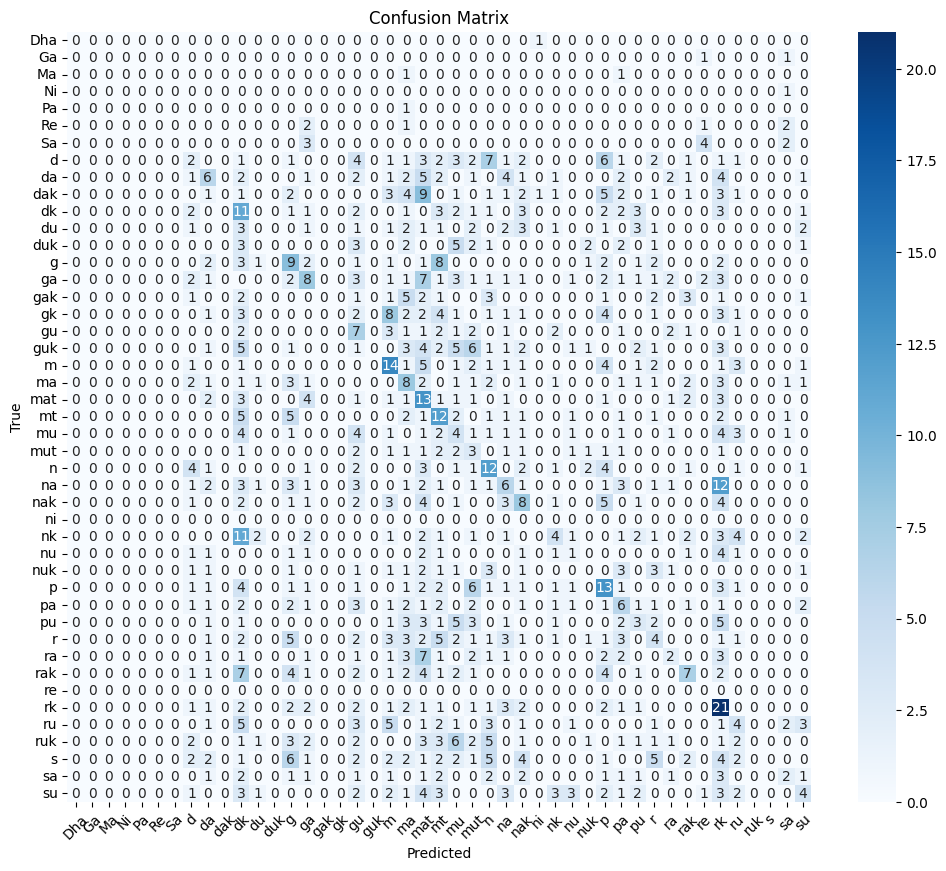

In [ ]:
# ==============================================================================
# Final Script: Fine-Tuning and Evaluating a Sargam Prediction Model
#
# Description:
# This script fine-tunes a BERT Masked Language Model to predict the final
# token in a Sargam sequence based on lyrics.
#
# IT REQUIRES PRE-SPLIT DATA: You must provide separate CSV files for
# training, validation, and testing.
#
# Author: Gemini (updated for compatibility with older transformers versions)
# Date: September 8, 2025
# ==============================================================================

# --- 0. Imports ---
try:
    import pandas as pd
    import torch
    from transformers import BertTokenizer, BertForMaskedLM, DataCollatorForLanguageModeling, Trainer, TrainingArguments
    from torch.utils.data import Dataset
    import torch.nn.functional as F
    from tqdm import tqdm
    import numpy as np
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    from sklearn.model_selection import train_test_split
    import matplotlib.pyplot as plt
    import seaborn as sns
except ImportError:
    print("Installing required libraries...")
    !pip install pandas torch transformers datasets scikit-learn matplotlib seaborn -q
    import pandas as pd
    import torch
    from transformers import BertTokenizer, BertForMaskedLM, DataCollatorForLanguageModeling, Trainer, TrainingArguments
    from torch.utils.data import Dataset
    import torch.nn.functional as F
    from tqdm import tqdm
    import numpy as np
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    from sklearn.model_selection import train_test_split
    import matplotlib.pyplot as plt
    import seaborn as sns
import os

# --- 1. Configuration ---
MODEL_NAME = "google-bert/bert-base-multilingual-uncased"
TRAIN_CSV_PATH = "/content/train.csv"
VALIDATION_CSV_PATH = "/content/validation.csv"
TEST_CSV_PATH = "/content/test.csv"
OUTPUT_CSV_PATH = "predictions_with_evaluation.csv"
MODEL_OUTPUT_DIR = "./mlm_sargam_model"

# Training Hyperparameters
EPOCHS = 8
BATCH_SIZE = 8
MAX_LEN = 128
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 2. Data Loading ---
def load_pre_split_data():
    try:
        print("📁 Loading pre-split data files...")
        train_df = pd.read_csv(TRAIN_CSV_PATH)
        val_df = pd.read_csv(VALIDATION_CSV_PATH)
        test_df = pd.read_csv(TEST_CSV_PATH)
        print(f"✅ Loaded {len(train_df)} train, {len(val_df)} validation, and {len(test_df)} test examples.")
        return train_df, val_df, test_df
    except FileNotFoundError as e:
        print(f"❌ ERROR: A required data file was not found. {e}")
        return None, None, None

def prepare_data_for_mlm(df):
    df['sargam'] = df['sargam'].astype(str)
    df['lyrics'] = df['lyrics'].astype(str)
    df['masked_sargam'] = df['sargam'].apply(lambda x: ' '.join(x.split()[:-1] + ['[MASK]']))
    df['training_text'] = df['lyrics'] + " [SEP] " + df['masked_sargam']
    return df

# --- 3. Custom Dataset ---
class SargamDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text, add_special_tokens=True, truncation=True,
            max_length=self.max_len, padding='max_length', return_tensors='pt'
        )
        return {k: v.squeeze(0) for k, v in encoding.items()}

# --- 4. Prediction & Evaluation ---
def evaluate_on_test_set(model, tokenizer, test_df):
    print("\n\n--- Final Evaluation on Test Set ---")
    y_true = [s.split()[-1] for s in test_df['sargam']]
    y_pred, confidences = [], []

    valid_sargam_syllables = [
        "sa", "re", "ga", "ma", "pa", "dha", "ni",
        "rak","ra","gak","mat","dak","da","nak","na",
        "rk","r","gk","g","m","mt","p","dk","d","nk","n",
        "su","ruk","ru","guk","gu","mu","mut","pu","duk","du","nuk","nu"
    ]
    valid_ids = [tid[0] for s in valid_sargam_syllables if len(tid := tokenizer.encode(s, add_special_tokens=False)) == 1]
    valid_ids_tensor = torch.tensor(valid_ids, device=DEVICE)

    model.eval()
    for _, row in tqdm(test_df.iterrows(), total=test_df.shape[0], desc="Evaluating"):
        text = row['training_text']
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=MAX_LEN).to(DEVICE)
        with torch.no_grad():
            logits = model(**inputs).logits
        try:
            mask_index = (inputs.input_ids[0] == tokenizer.mask_token_id).nonzero(as_tuple=True)[0][0]
            mask_logits = logits[0, mask_index, :]
            filtered_logits = torch.full_like(mask_logits, -float("inf"))
            filtered_logits[valid_ids_tensor] = mask_logits[valid_ids_tensor]
            probs = torch.nn.functional.softmax(filtered_logits, dim=-1)
            best_id = torch.argmax(probs).item()
            y_pred.append(tokenizer.decode(best_id))
            confidences.append(probs[best_id].item())
        except IndexError:
            y_pred.append("[ERROR]")
            confidences.append(0.0)

    results_df = test_df.copy()
    results_df['predicted_token'] = y_pred
    results_df['ground_truth_token'] = y_true
    results_df['is_correct'] = np.where(results_df['predicted_token'] == results_df['ground_truth_token'], 'Yes', 'No')
    results_df['confidence'] = [f"{c:.2%}" for c in confidences]
    results_df.to_csv(OUTPUT_CSV_PATH, index=False)
    print(f"\n✅ Saved detailed results to {OUTPUT_CSV_PATH}")

    print("\n🎯 Accuracy:", f"{accuracy_score(y_true, y_pred):.2%}")
    print("\n📊 Classification Report:")
    unique_labels = sorted(list(set(y_true) | set(y_pred)))
    print(classification_report(y_true, y_pred, labels=unique_labels, zero_division=0))

    cm = confusion_matrix(y_true, y_pred, labels=unique_labels)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=unique_labels, yticklabels=unique_labels)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

# --- 5. Main Execution ---
def main():
    train_df, val_df, test_df = load_pre_split_data()
    if train_df is None: return

    train_df = prepare_data_for_mlm(train_df)
    val_df = prepare_data_for_mlm(val_df)
    test_df = prepare_data_for_mlm(test_df)

    tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
    model = BertForMaskedLM.from_pretrained(MODEL_NAME).to(DEVICE)

    train_dataset = SargamDataset(train_df['training_text'].tolist(), tokenizer, MAX_LEN)
    val_dataset = SargamDataset(val_df['training_text'].tolist(), tokenizer, MAX_LEN)

    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15)

    # --- FIXED Training Arguments (compatible with old transformers) ---
    training_args = TrainingArguments(
        output_dir=MODEL_OUTPUT_DIR,
        overwrite_output_dir=True,
        logging_dir="./logs",
        logging_steps=100,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        num_train_epochs=EPOCHS,
        seed=42
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
    )

    print("\n🚀 Starting Training...")
    trainer.train()
    print("✅ Training complete!")

    evaluate_on_test_set(trainer.model, tokenizer, test_df)

if __name__ == "__main__":
    if not all(os.path.exists(f) for f in [TRAIN_CSV_PATH, VALIDATION_CSV_PATH, TEST_CSV_PATH]):
        print("Creating dummy train/val/test CSVs...")
        dummy_data = {
            'lyrics': ["Twinkle Twinkle", "Old MacDonald", "Mary Had a Lamb"] * 50,
            'sargam': ["sa re ga ma pa", "sa sa ga ga ma", "ga re ga re sa"] * 50
        }
        df = pd.DataFrame(dummy_data)
        train, temp = train_test_split(df, test_size=0.3, random_state=42)
        val, test = train_test_split(temp, test_size=0.5, random_state=42)
        train.to_csv(TRAIN_CSV_PATH, index=False)
        val.to_csv(VALIDATION_CSV_PATH, index=False)
        test.to_csv(TEST_CSV_PATH, index=False)
        print("✅ Dummy CSVs created.")
    main()


In [ ]:
import pandas as pd

# --- Load your CSV ---
file_path = "/content/predictions_with_evaluation (2).csv"   # change to your actual file
df = pd.read_csv(file_path)

# --- 1. Count total entries ---
total_entries = len(df)
print(f"Total number of entries: {total_entries}")

# --- 2. Filter rows where label == true ---
# assuming label column contains True/False or string "true"/"false"
filtered_df = df[df['label'].astype(str).str.lower() == 'true']

# --- Save to a new CSV ---
filtered_df.to_csv("true_labels.csv", index=False)
print(f"Saved {len(filtered_df)} rows with label=true to 'true_labels.csv'")


Total number of entries: 1289
Saved 512 rows with label=true to 'true_labels.csv'


In [ ]:
import pandas as pd

# --- Load CSV ---
file_path = "/content/true_labels.csv"   # change to your file
df = pd.read_csv(file_path)

# --- 1. Total entries ---
total_entries = len(df)

# --- 2. Count rows where is_correct == "Yes" ---
yes_count = (df['is_correct'].astype(str).str.strip().str.lower() == "yes").sum()

# --- Print results ---
print(f"📊 Total number of entries: {total_entries}")
print(f"✅ Number of rows with is_correct = Yes: {yes_count}")


📊 Total number of entries: 512
✅ Number of rows with is_correct = Yes: 69


In [ ]:
!pip install --upgrade transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 101.7 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.56.0
    Uninstalling transformers-4.56.0:
      Successfully uninstalled transformers-4.56.0


📁 Loading pre-split data files...
✅ Loaded 4508 train, 644 validation, and 1289 test examples.


Some weights of the model checkpoint at google-bert/bert-base-multilingual-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipython-input-2528405890.py:180: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



🚀 Starting Training...


Step,Training Loss
100,2.479000
200,1.784000
300,1.442700
400,1.217500
500,1.138100
600,1.103100
700,0.993100
800,0.896600
900,0.897400
1000,0.856700


✅ Training complete!


--- Final Evaluation on Test Set ---


Evaluating: 100%|██████████| 1289/1289 [00:16<00:00, 80.33it/s]



✅ Saved detailed results to predictions_with_evaluation.csv

🎯 Accuracy: 5.51%

📊 Classification Report:
              precision    recall  f1-score   support

     Dha Dha       0.00      0.00      0.00         1
      Dha Ma       0.00      0.00      0.00         1
       Ga Ga       0.00      0.00      0.00         1
       Ga Re       0.00      0.00      0.00         1
      Mat Re       0.00      0.00      0.00         1
       Pa Ma       0.00      0.00      0.00         1
       Pa Pa       0.00      0.00      0.00         1
       Re Ga       0.00      0.00      0.00         1
       Re Re       0.00      0.00      0.00         2
       Re Sa       0.00      0.00      0.00         4
       Sa Ni       0.00      0.00      0.00         1
       Sa Re       0.00      0.00      0.00         2
       Sa Sa       0.00      0.00      0.00         5
         d d       0.21      0.38      0.27        13
        d dk       0.50      0.50      0.50         2
       d duk       0.00      

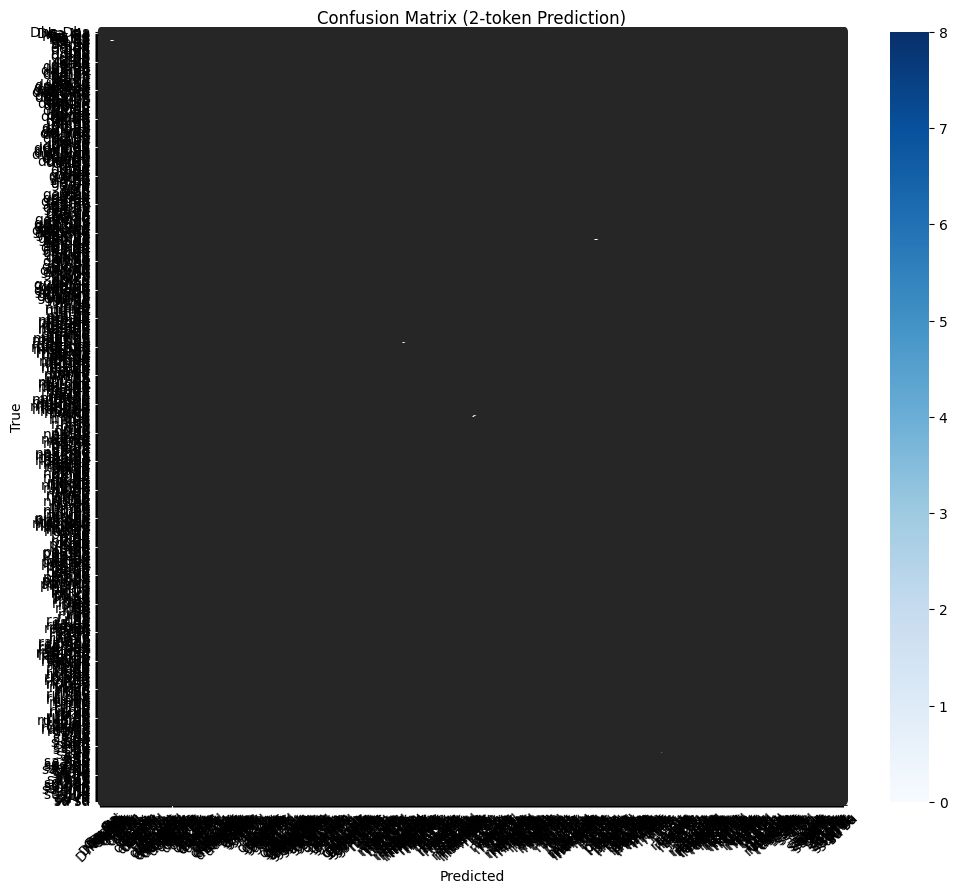

In [ ]:
# ==============================================================================
# Final Script: Fine-Tuning and Evaluating a Sargam Prediction Model
#
# Description:
# This script fine-tunes a BERT Masked Language Model to predict the last
# 2 tokens in a Sargam sequence based on lyrics.
#
# Author: Aditya + Gemini
# Date: September 8, 2025
# ==============================================================================

# --- 0. Imports ---
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    BertTokenizer,
    BertForMaskedLM,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments,
    get_linear_schedule_with_warmup,   # ✅ Added scheduler
)
import torch.nn.functional as F
from torch.optim import AdamW         # ✅ AdamW from torch
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- 1. Configuration ---
MODEL_NAME = "google-bert/bert-base-multilingual-uncased"
TRAIN_CSV_PATH = "/content/train.csv"
VALIDATION_CSV_PATH = "/content/validation.csv"
TEST_CSV_PATH = "/content/test.csv"
OUTPUT_CSV_PATH = "predictions_with_evaluation.csv"
MODEL_OUTPUT_DIR = "./mlm_sargam_model"

# Training Hyperparameters
EPOCHS = 8
BATCH_SIZE = 8
MAX_LEN = 128
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 2. Data Loading ---
def load_pre_split_data():
    try:
        print("📁 Loading pre-split data files...")
        train_df = pd.read_csv(TRAIN_CSV_PATH)
        val_df = pd.read_csv(VALIDATION_CSV_PATH)
        test_df = pd.read_csv(TEST_CSV_PATH)
        print(f"✅ Loaded {len(train_df)} train, {len(val_df)} validation, and {len(test_df)} test examples.")
        return train_df, val_df, test_df
    except FileNotFoundError as e:
        print(f"❌ ERROR: A required data file was not found. {e}")
        return None, None, None

def prepare_data_for_mlm(df):
    df['sargam'] = df['sargam'].astype(str)
    df['lyrics'] = df['lyrics'].astype(str)
    # Replace last 2 tokens with [MASK]
    df['masked_sargam'] = df['sargam'].apply(
        lambda x: ' '.join(x.split()[:-2] + ['[MASK]', '[MASK]']) if len(x.split()) >= 2 else x + ' [MASK]'
    )
    df['training_text'] = df['lyrics'] + " [SEP] " + df['masked_sargam']
    return df

# --- 3. Custom Dataset ---
class SargamDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text, add_special_tokens=True, truncation=True,
            max_length=self.max_len, padding='max_length', return_tensors='pt'
        )
        return {k: v.squeeze(0) for k, v in encoding.items()}

# --- 4. Prediction & Evaluation ---
def evaluate_on_test_set(model, tokenizer, test_df):
    print("\n\n--- Final Evaluation on Test Set ---")
    y_true = [' '.join(s.split()[-2:]) for s in test_df['sargam']]  # last 2 tokens
    y_pred, confidences = [], []

    # Define valid tokens (extendable)
    valid_sargam_syllables = [
        "sa","re","ga","ma","pa","dha","ni",
        "rak","ra","gak","mat","dak","da","nak","na",
        "rk","r","gk","g","m","mt","p","dk","d","nk","n",
        "su","ruk","ru","guk","gu","mu","mut","pu","duk","du","nuk","nu"
    ]
    valid_ids = [tid[0] for s in valid_sargam_syllables if len(tid := tokenizer.encode(s, add_special_tokens=False)) == 1]
    valid_ids_tensor = torch.tensor(valid_ids, device=DEVICE)

    model.eval()
    for _, row in tqdm(test_df.iterrows(), total=test_df.shape[0], desc="Evaluating"):
        text = row['training_text']
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=MAX_LEN).to(DEVICE)
        with torch.no_grad():
            logits = model(**inputs).logits

        # Find mask positions
        mask_positions = (inputs.input_ids[0] == tokenizer.mask_token_id).nonzero(as_tuple=True)[0]
        predicted_tokens, probs_list = [], []
        for pos in mask_positions:
            mask_logits = logits[0, pos, :]
            filtered_logits = torch.full_like(mask_logits, -float("inf"))
            filtered_logits[valid_ids_tensor] = mask_logits[valid_ids_tensor]
            probs = torch.nn.functional.softmax(filtered_logits, dim=-1)
            best_id = torch.argmax(probs).item()
            predicted_tokens.append(tokenizer.decode(best_id))
            probs_list.append(probs[best_id].item())

        y_pred.append(" ".join(predicted_tokens))
        confidences.append(np.mean(probs_list) if probs_list else 0.0)

    results_df = test_df.copy()
    results_df['predicted_tokens'] = y_pred
    results_df['ground_truth_tokens'] = y_true
    results_df['is_correct'] = np.where(results_df['predicted_tokens'] == results_df['ground_truth_tokens'], 'Yes', 'No')
    results_df['confidence'] = [f"{c:.2%}" for c in confidences]
    results_df.to_csv(OUTPUT_CSV_PATH, index=False)
    print(f"\n✅ Saved detailed results to {OUTPUT_CSV_PATH}")

    print("\n🎯 Accuracy:", f"{accuracy_score(y_true, y_pred):.2%}")
    print("\n📊 Classification Report:")
    unique_labels = sorted(list(set(y_true) | set(y_pred)))
    print(classification_report(y_true, y_pred, labels=unique_labels, zero_division=0))

    cm = confusion_matrix(y_true, y_pred, labels=unique_labels)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=unique_labels, yticklabels=unique_labels)
    plt.title("Confusion Matrix (2-token Prediction)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

# --- 5. Main Execution ---
def main():
    train_df, val_df, test_df = load_pre_split_data()
    if train_df is None: return

    train_df = prepare_data_for_mlm(train_df)
    val_df = prepare_data_for_mlm(val_df)
    test_df = prepare_data_for_mlm(test_df)

    tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
    model = BertForMaskedLM.from_pretrained(MODEL_NAME).to(DEVICE)

    train_dataset = SargamDataset(train_df['training_text'].tolist(), tokenizer, MAX_LEN)
    val_dataset = SargamDataset(val_df['training_text'].tolist(), tokenizer, MAX_LEN)

    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15)

    # --- Training Arguments ---
    training_args = TrainingArguments(
        output_dir=MODEL_OUTPUT_DIR,
        overwrite_output_dir=True,
        logging_dir="./logs",
        logging_steps=100,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        num_train_epochs=EPOCHS,
        seed=42
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
    )

    print("\n🚀 Starting Training...")
    trainer.train()
    print("✅ Training complete!")

    evaluate_on_test_set(trainer.model, tokenizer, test_df)

if __name__ == "__main__":
    if not all(os.path.exists(f) for f in [TRAIN_CSV_PATH, VALIDATION_CSV_PATH, TEST_CSV_PATH]):
        print("Creating dummy train/val/test CSVs...")
        dummy_data = {
            'lyrics': ["Twinkle Twinkle", "Old MacDonald", "Mary Had a Lamb"] * 50,
            'sargam': ["sa re ga ma pa", "sa sa ga ga ma", "ga re ga re sa"] * 50
        }
        df = pd.DataFrame(dummy_data)
        train, temp = train_test_split(df, test_size=0.3, random_state=42)
        val, test = train_test_split(temp, test_size=0.5, random_state=42)
        train.to_csv(TRAIN_CSV_PATH, index=False)
        val.to_csv(VALIDATION_CSV_PATH, index=False)
        test.to_csv(TEST_CSV_PATH, index=False)
        print("✅ Dummy CSVs created.")
    main()
